# COMP5310 PROJECT STAGE 2
### Assignment Group 30
### SID1: 540908237, SID2: 540844821 - mrau0998 , SID3: 

## Setup and Dependencies
This section imports all required libraries for preprocessing, modeling, evaluation, and visualization.

In [1]:
# Import all dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import keras_tuner as kt

## Data Loading and Preprocessing
This section contains the code for loading and preprocessing the data.

In [2]:
# Import data

data = pd.read_csv("vsup0468_A1_CleanDataset.csv")
data.head()

,Make_Model,Price,Mileage,Fuel,Age,Previous_Owners,Horsepower,Gearing_Type,Displacement,Drive_Chain
0,Audi A1,15770.0,56012.8,Benzine,3.0,1.0,66.0,Automatic,1422.0,front
1,Audi A1,14640.0,83449.8,Diesel,3.0,1.0,85.0,Automatic,1461.0,front
2,Audi A1,16422.0,62110.8,Diesel,3.0,1.0,85.0,Automatic,1598.0,front
3,Audi A1,17990.0,26414.9,Benzine,3.0,1.0,85.0,Automatic,1461.0,front
4,Audi A1,18900.0,9752.0,Diesel,1.0,1.0,85.0,Automatic,1598.0,front


In [3]:
# Separate the features and target variable.

features_df = data.drop("Price", axis=1)
target_df = data["Price"]

In [4]:
# View the first 5 rows of features_df

features_df.head()

,Make_Model,Mileage,Fuel,Age,Previous_Owners,Horsepower,Gearing_Type,Displacement,Drive_Chain
0,Audi A1,56012.8,Benzine,3.0,1.0,66.0,Automatic,1422.0,front
1,Audi A1,83449.8,Diesel,3.0,1.0,85.0,Automatic,1461.0,front
2,Audi A1,62110.8,Diesel,3.0,1.0,85.0,Automatic,1598.0,front
3,Audi A1,26414.9,Benzine,3.0,1.0,85.0,Automatic,1461.0,front
4,Audi A1,9752.0,Diesel,1.0,1.0,85.0,Automatic,1598.0,front


In [5]:
# View the first 5 rows of target_df

target_df.head()

0    15770.0
1    14640.0
2    16422.0
3    17990.0
4    18900.0
Name: Price, dtype: float64

In [6]:
# Data preprocessing

## Define categorical and numerical features
categorical_features = features_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Preprocess categorical columns with one-hot encoding and scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

features_df_preprocessed = preprocessor.fit_transform(features_df)

## Convert dataframe to numpy array
X_full = features_df_preprocessed
y_full = target_df.values

In [7]:
# Split full dataset to train, val, and test sets

# First split: train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.2, random_state=5310
)

# Second split: validation (10%) and test (10%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=5310
)

In [8]:
# validate the train, val and test sets shape

print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (2783, 23)
Shape of y_train = (2783,)
Shape of X_val = (348, 23)
Shape of y_val = (348,)
Shape of X_test = (348, 23)
Shape of y_test = (348,)


## Predictive Models
This section contains the code for creating, optimizing, and evaluating the models.

### 1. Multilayer Perceptron (MLP)

Pseudocode:

#### Base setup for MLP model

In [ ]:
# Define MLP Model
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile MLP model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train MLP model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = mlp_model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=50, 
                        batch_size=32, 
                        callbacks=[early_stop])

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot predictions vs actual

y_pred = mlp_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices From Baseline MLP Model")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # perfect line
plt.show()

In [ ]:
# Evaluate the Model

# Compute MSE and MAE
loss, mae = mlp_model.evaluate(X_test, y_test)
print(f"Baseline MSE: {loss:.4f}")
print(f"Baseline MAE: {mae:.4f}")


#### Hyperparameter tuning for MLP model

In [ ]:
# Define function to do hyperparameter tuning

def build_mlp_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    
    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
    
    model.add(tf.keras.layers.Dense(1))  # output layer for regression
    
    # Compile with tuned learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [ ]:
# Initialize the tuner

tuner = kt.RandomSearch(
    build_mlp_model,
    objective='val_mae',
    max_trials=50,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='car_price_mlp'
)

In [ ]:
# Search for the Best Hyperparameters

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stop])

In [ ]:
# Retrieve the Best Model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for param in best_hps.values:
    print(f" - {param}: {best_hps.get(param)}")

In [ ]:
# Build and train final model

best_model = tuner.hypermodel.build(best_hps)
best_history = best_model.fit(X_train, y_train, 
                              validation_data=(X_val, y_val), 
                              epochs=50, 
                              batch_size=32, 
                              callbacks=[early_stop])

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(best_history.history['mae'], label='Training MAE')
plt.plot(best_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot predictions vs actual

y_pred = best_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices From MLP Best Model")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # perfect line
plt.show()

In [ ]:
# Evaluate the Best Model

# Compute MSE and MAE
loss, mae = best_model.evaluate(X_test, y_test)
print(f"BEST MSE: {loss:.4f}")
print(f"BEST MAE: {mae:.4f}")


In [ ]:
# Use Trained Best MLP Model to Predict on New Data

new_data = pd.DataFrame([{
    'Make_Model': 'Audi A1',
    'Mileage': 54000.0,
    'Fuel': 'Benzine',
    'Age': 3.0,
    'Previous_Owners': 1.0,
    'Horsepower': 85.0,
    'Gearing_Type': 'Automatic',
    'Displacement': 1600.0,
    'Drive_Chain': 'front'
}])

# Preprocess the New Data Using the Same Fitted Preprocessor
new_data_processed = preprocessor.transform(new_data)

predicted_price = best_model.predict(new_data_processed)
print(f"Predicted price: ${predicted_price[0][0]:,.2f} ± approx. ${mae:,.0f} (based on test MAE)")


### CatBoost (Categorical Boosting) - Unikey: mrau0998

Pseudocode:

#### Base Setup for CatBoost Model

In [9]:
# Split raw data for CatBoost
X_cb_train, X_cb_temp, y_cb_train, y_cb_temp = train_test_split(
    features_df, target_df, test_size=0.2, random_state=5310
)

X_cb_val, X_cb_test, y_cb_val, y_cb_test = train_test_split(
    X_cb_temp, y_cb_temp, test_size=0.5, random_state=5310
)

In [10]:
# Define categorical feature names (these are raw, unencoded)
categorical_features = ['Make_Model', 'Fuel', 'Gearing_Type', 'Drive_Chain']

# Initialize CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=5310
)

# Train the model using raw data and native categorical support
catboost_model.fit(
    X_cb_train, y_cb_train,
    eval_set=(X_cb_val, y_cb_val),
    use_best_model=True
)

0:	learn: 10602.8688131	test: 6456.1137236	best: 6456.1137236 (0)	total: 172ms	remaining: 2m 51s
100:	learn: 8061.6494633	test: 3494.5797666	best: 3494.3732925 (99)	total: 4.25s	remaining: 37.9s
200:	learn: 7530.6426853	test: 3413.6532713	best: 3413.6117960 (198)	total: 8.37s	remaining: 33.3s
300:	learn: 6467.7670757	test: 3380.9605260	best: 3370.6510099 (271)	total: 12.5s	remaining: 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3370.65101
bestIteration = 271

Shrink model to first 272 iterations.


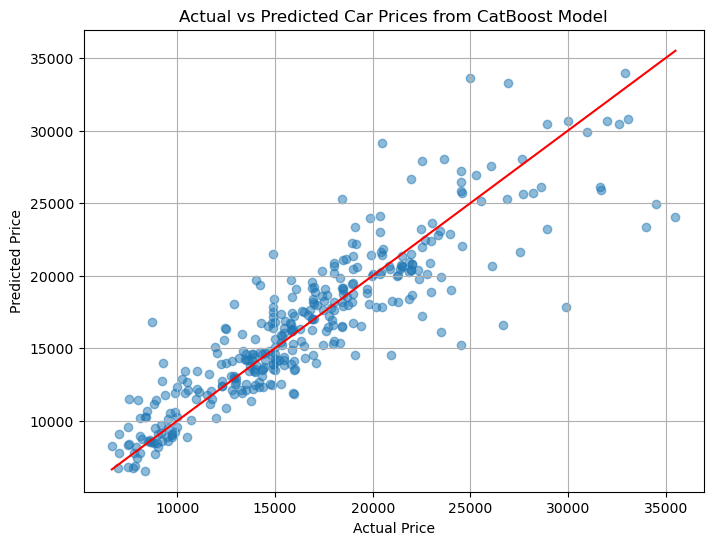

In [11]:
# Predict using CatBoost model
y_cb_pred = catboost_model.predict(X_cb_test)

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_cb_test, y_cb_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices from CatBoost Model")
plt.plot([min(y_cb_test), max(y_cb_test)], [min(y_cb_test), max(y_cb_test)], color='red')  # perfect prediction line
plt.grid(True)
plt.show()

In [12]:
# Predict on test set
y_cb_pred = catboost_model.predict(X_cb_test)

# Compute evaluation metrics
mse = mean_squared_error(y_cb_test, y_cb_pred)
mae = mean_absolute_error(y_cb_test, y_cb_pred)
r2 = r2_score(y_cb_test, y_cb_pred)

# Display results
print(f"CatBoost MSE: {mse:.4f}")
print(f"CatBoost MAE: {mae:.4f}")
print(f"CatBoost R²: {r2:.4f}")

CatBoost MSE: 6974258.8396
CatBoost MAE: 1808.0972
CatBoost R²: 0.7913


#### Hyperparameter tuning for CatBoost model

In [14]:
# Initiate the CatBoost model
cb_model = CatBoostRegressor(
    verbose=200, 
    cat_features=categorical_features,
    loss_function='RMSE',
    early_stopping_rounds=50,
    random_seed=5310
)

# Declare the parameters to be tested
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'iterations': [500,1000]
}

# Perform grid search
grid_search = GridSearchCV(cb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_cb_train, y_cb_train)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 10703.1689579	total: 50.1ms	remaining: 50.1s
200:	learn: 8543.2479428	total: 10.9s	remaining: 43.3s
400:	learn: 7988.3353699	total: 21s	remaining: 31.4s
600:	learn: 7739.7286674	total: 30.4s	remaining: 20.2s
800:	learn: 7399.4788905	total: 39.9s	remaining: 9.9s
999:	learn: 7058.5969206	total: 50.2s	remaining: 0us
Best params: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.01}
Best score: 74700636.72512157


In [16]:
# Get the best performing model
cb_model_best = grid_search.best_estimator_

# Train the model on the full training data
cb_model_best.fit(X_cb_train, y_cb_train, eval_set=(X_cb_val, y_cb_val), verbose=200)

0:	learn: 10703.1689579	test: 6586.1724818	best: 6586.1724818 (0)	total: 60.6ms	remaining: 1m
200:	learn: 8543.2479428	test: 3768.7056641	best: 3768.7056641 (200)	total: 11.3s	remaining: 44.9s
400:	learn: 7988.3353699	test: 3487.6193597	best: 3487.6193597 (400)	total: 21.8s	remaining: 32.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3408.275894
bestIteration = 544

Shrink model to first 545 iterations.


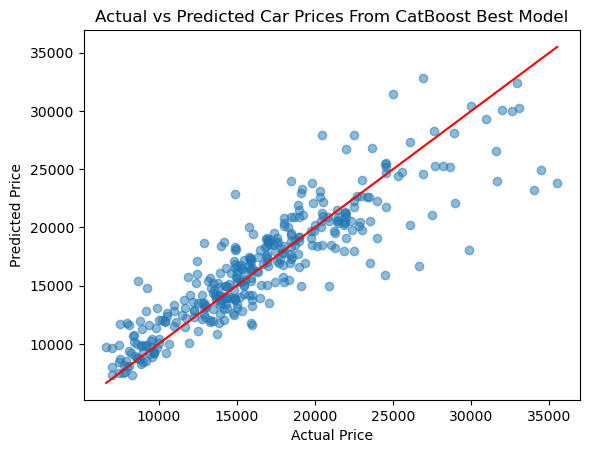

In [17]:
# Make predictions on the test set
y_cb_pred = cb_model_best.predict(X_cb_test)

# Plot predictions vs actual values
plt.scatter(y_cb_test, y_cb_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices From CatBoost Best Model")

# Plot a perfect line (diagonal line) representing ideal predictions
plt.plot([min(y_cb_test), max(y_cb_test)], [min(y_cb_test), max(y_cb_test)], color='red')  # perfect line
plt.show()

In [18]:
mse = mean_squared_error(y_cb_test, y_cb_pred)
mae = mean_absolute_error(y_cb_test, y_cb_pred)
r2 = r2_score(y_cb_test, y_cb_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2: {r2:.4f}")

Test MSE: 6809784.8884
Test MAE: 1796.7196
Test R^2: 0.7963


In [19]:
# New data (same structure as the original dataset)
new_data = pd.DataFrame([{
    'Make_Model': 'Audi A1',
    'Mileage': 54000.0,
    'Fuel': 'Benzine',
    'Age': 3.0,
    'Previous_Owners': 1.0,
    'Horsepower': 85.0,
    'Gearing_Type': 'Automatic',
    'Displacement': 1600.0,
    'Drive_Chain': 'front'
}])

# Make prediction using the best trained CatBoost model
predicted_price = cb_model_best.predict(new_data)

# Compute MAE from previous evaluation to provide the uncertainty
# You can also use the test MAE directly
print(f"Predicted price for new data: ${predicted_price[0]:,.2f} ± approx. ${mae:,.0f} (based on test MAE)")

Predicted price for new data: $17,544.97 ± approx. $1,797 (based on test MAE)
